In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import joblib
import argparse
from datetime import datetime
import os

In [2]:
def load_model_components(model_path='compressor_autoencoder2.h5',
                          scaler_path='scaler2.pkl',
                          config_path='model_config2.pkl'):
    """Load the saved model, scaler, and configuration"""
    print("="*70)
    print("LOADING MODEL COMPONENTS")
    print("="*70)

    try:
        model_path = "D:\Projects\LSTM_Autoencoder\.venv\Scripts\compressor_autoencoder2.h5"
        model = load_model(model_path, compile=False)
        print("   ✓ Model loaded successfully")
    
    # Recompile the model with fresh optimizer
        from tensorflow.keras.optimizers import Adam
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
            )
        print("   ✓ Model recompiled")
    
    # Load scaler
        scaler_path = "D:\Projects\LSTM_Autoencoder\.venv\Scripts\scaler2.pkl"
        scaler = joblib.load(scaler_path)
        print("   ✓ Scaler loaded successfully")
    
    # Load config
        print(f"\n📦 Loading config from: {config_path}")
        config_path = "D:\Projects\LSTM_Autoencoder\.venv\Scripts\model_config2.pkl"
  
        config = joblib.load(config_path)
        threshold = config['threshold']
        feature_columns = config['features']
        print("   ✓ Config loaded successfully")
    
        print(f"\n📋 Model Configuration:")
        print(f"   Threshold: {threshold:.6f}")
        print(f"   Features ({len(feature_columns)}):")
        for i, col in enumerate(feature_columns, 1):
            print(f"      {i}. {col}")
    
        return model, scaler, threshold, feature_columns
    
    except Exception as e:
        print(f"\n❌ Error loading model components: {str(e)}")
        print("\nTroubleshooting:")
        print("  1. Check TensorFlow version: pip show tensorflow")
        print("  2. Verify model files exist and are not corrupted")
        print(f"\n  Model path: {model_path}")
        print(f"  Scaler path: {scaler_path}")
        print(f"  Config path: {config_path}")
    return None, None, None, None




def preprocess_test_data(df, scaler, feature_columns):
    """Preprocess test data using saved scaler"""
    print("\n" + "="*70)
    print("PREPROCESSING TEST DATA")
    print("="*70)
    
    print(f"\n📊 Test Data Info:")
    print(f"   Total rows: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    
    # Check for compressor_id column
    has_compressor_id = 'compressor_id' in df.columns
    if has_compressor_id:
        unique_compressors = df['compressor_id'].unique()
        print(f"   Compressors found: {list(unique_compressors)}")
        for comp_id in unique_compressors:
            count = (df['compressor_id'] == comp_id).sum()
            print(f"      - Compressor {comp_id}: {count} samples")
    else:
        print(f"   ⚠️  No 'compressor_id' column found - will treat all data as single compressor")
    
    # Check if timestamp exists
    has_timestamp = 'timestamp' in df.columns
    if has_timestamp:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp')
        print(f"   Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    # Check for missing features
    missing_features = set(feature_columns) - set(df.columns)
    if missing_features:
        print(f"\n⚠️  Warning: Missing features in test data: {missing_features}")
        print("   Adding missing features with zeros...")
        for feat in missing_features:
            df[feat] = 0
    
    # Select and order features
    df_features = df[feature_columns].copy()
    
    # Handle missing values
    if df_features.isnull().any().any():
        print(f"\n⚠️  Warning: Found missing values, filling with forward fill...")
        df_features = df_features.fillna(method='ffill').fillna(method='bfill')
    
    # Scale data
    print(f"\n🔧 Scaling data using saved scaler...")
    scaled_data = scaler.transform(df_features)
    print(f"   ✓ Data scaled successfully")
    
    return scaled_data, df



def create_sequences(data, sequence_length):
    """Create sequences for LSTM"""
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:(i + sequence_length)])
    return np.array(sequences)


In [3]:
def test_model(model, scaler, threshold, feature_columns, test_csv_path, 
               sequence_length=10, consecutive_threshold=3):
    """
    Test the model on new CSV data
    
    Parameters:
    - test_csv_path: Path to test CSV file
    - sequence_length: Same as training (default: 10)
    - consecutive_threshold: Number of consecutive anomalies to trigger alert (default: 3)
    
    Note: If CSV contains 'compressor_id' column, results will be grouped by compressor
    """
    print("\n" + "="*70)
    print("TESTING SAVED MODEL")
    print("="*70)
    
    # Load test data
    print(f"\n📂 Loading test data from: {test_csv_path}")
    if not os.path.exists(test_csv_path):
        print(f"❌ Error: File not found: {test_csv_path}")
        return None
    
    df = pd.read_csv(test_csv_path)
    print(f"   ✓ Loaded {len(df)} rows")
    
    # Preprocess
    scaled_data, df_original = preprocess_test_data(df, scaler, feature_columns)
    
    # Create sequences
    print(f"\n🔄 Creating sequences (length={sequence_length})...")
    sequences = create_sequences(scaled_data, sequence_length)
    print(f"   ✓ Created {len(sequences)} sequences")
    
    if len(sequences) == 0:
        print(f"\n❌ Error: Not enough data to create sequences.")
        print(f"   Need at least {sequence_length} samples, but got {len(df)}")
        return None
    
    # Predict
    print(f"\n🤖 Running model predictions...")
    predictions = model.predict(sequences, verbose=0)
    print(f"   ✓ Predictions complete")
    
    # Calculate reconstruction errors
    print(f"\n📊 Calculating reconstruction errors...")
    mse = np.mean(np.power(sequences - predictions, 2), axis=(1, 2))
    
    # Feature-level errors
    feature_mse = np.mean(np.power(sequences - predictions, 2), axis=1)
    
    # Detect anomalies
    is_anomaly_point = mse > threshold
    
    # Apply consecutive threshold
    triggered_anomaly = np.zeros(len(mse), dtype=bool)
    consecutive_count = np.zeros(len(mse), dtype=int)
    
    consecutive = 0
    for i in range(len(is_anomaly_point)):
        if is_anomaly_point[i]:
            consecutive += 1
            if consecutive >= consecutive_threshold:
                start_idx = max(0, i - consecutive + 1)
                triggered_anomaly[start_idx:i+1] = True
        else:
            consecutive = 0
        consecutive_count[i] = consecutive
    
    # Create results DataFrame
    results = pd.DataFrame({
        'sequence_index': range(len(mse)),
        'reconstruction_error': mse,
        'threshold': threshold,
        'is_anomaly_point': is_anomaly_point,
        'triggered_anomaly': triggered_anomaly,
        'anomaly_score': mse / threshold,
        'consecutive_count': consecutive_count
    })
    
    # Add feature errors
    for i, col in enumerate(feature_columns):
        results[f'error_{col}'] = feature_mse[:, i]
    
    # Add timestamps if available
    if 'timestamp' in df_original.columns:
        start_idx = sequence_length - 1
        results['timestamp'] = df_original['timestamp'].iloc[start_idx:start_idx + len(results)].values
    
    # Add compressor_id if available (IMPORTANT!)
    if 'compressor_id' in df_original.columns:
        start_idx = sequence_length - 1
        results['compressor_id'] = df_original['compressor_id'].iloc[start_idx:start_idx + len(results)].values
        print(f"   ✓ Compressor IDs tracked in results")
    
    # Print summary
    print_test_summary(results, feature_columns, consecutive_threshold)
    
    # Analyze anomalous features (overall and per compressor)
    if triggered_anomaly.sum() > 0:
        analyze_anomalous_features(results, feature_columns)
        
        # If multiple compressors, analyze each separately
        if 'compressor_id' in results.columns:
            analyze_by_compressor(results, feature_columns)
    
    return results

In [4]:
test_csv_path

NameError: name 'test_csv_path' is not defined

In [5]:
def print_test_summary(results, feature_columns, consecutive_threshold):
    """Print test results summary"""
    print("\n" + "="*70)
    print("TEST RESULTS SUMMARY")
    print("n" + "="*70)
    
    total = len(results)
    anomaly_points = results['is_anomaly_point'].sum()
    triggered = results['triggered_anomaly'].sum()
    
    print(f"\n📈 Overall Statistics:")
    print(f"   Total sequences analyzed: {total}")
    print(f"   Points exceeding threshold: {anomaly_points} ({100*anomaly_points/total:.2f}%)")
    print(f"   Triggered anomalies (≥{consecutive_threshold} consecutive): {triggered} ({100*triggered/total:.2f}%)")
    
    print(f"\n📊 Reconstruction Error Statistics:")
    print(f"   Mean:   {results['reconstruction_error'].mean():.6f}")
    print(f"   Median: {results['reconstruction_error'].median():.6f}")
    print(f"   Std:    {results['reconstruction_error'].std():.6f}")
    print(f"   Min:    {results['reconstruction_error'].min():.6f}")
    print(f"   Max:    {results['reconstruction_error'].max():.6f}")
    
    print(f"\n🎯 Anomaly Score Statistics (>1.0 = anomalous):")
    print(f"   Mean:   {results['anomaly_score'].mean():.3f}")
    print(f"   Median: {results['anomaly_score'].median():.3f}")
    print(f"   Max:    {results['anomaly_score'].max():.3f}")
    
    print(f"\n🎚️  Threshold: {results['threshold'].iloc[0]:.6f}")
    
    if triggered > 0:
        print(f"\n⚠️  ANOMALIES DETECTED!")
        print(f"   {triggered} sequences triggered anomaly alerts")
        
        if 'timestamp' in results.columns:
            triggered_df = results[results['triggered_anomaly']]
            print(f"\n   First anomaly: {triggered_df['timestamp'].iloc[0]}")
            print(f"   Last anomaly:  {triggered_df['timestamp'].iloc[-1]}")
            
            print(f"\n   Top 5 Highest Anomaly Scores:")
            top_anomalies = results.nlargest(5, 'anomaly_score')[
                ['sequence_index', 'reconstruction_error', 'anomaly_score', 'timestamp']
            ]
            print(top_anomalies.to_string(index=False))
    else:
        print(f"\n✓ No anomalies detected - system operating normally")



def analyze_anomalous_features(results, feature_columns):
    """Analyze which features contribute most to anomalies"""
    print("\n" + "="*70)
    print("ANOMALOUS FEATURE ANALYSIS - OVERALL")
    print("="*70)
    
    error_cols = [f'error_{col}' for col in feature_columns]
    
    triggered = results['triggered_anomaly']
    if triggered.sum() == 0:
        return
    
    # Calculate mean errors
    anomaly_errors = results[triggered][error_cols].mean()
    normal_errors = results[~triggered][error_cols].mean() if (~triggered).sum() > 0 else pd.Series(np.zeros(len(error_cols)), index=error_cols)
    
    # Create contribution table
    feature_contribution = pd.DataFrame({
        'feature': feature_columns,
        'normal_error': normal_errors.values,
        'anomaly_error': anomaly_errors.values,
        'increase_ratio': (anomaly_errors / (normal_errors + 1e-10)).values,
        'contribution_pct': 100 * anomaly_errors / anomaly_errors.sum()
    })
    
    feature_contribution = feature_contribution.sort_values('contribution_pct', ascending=False)
    
    print(f"\n🔍 Top 10 Contributing Features:")
    print("-" * 70)
    print(f"{'Rank':<6}{'Feature':<35}{'Contribution':<15}{'Increase':<15}")
    print("-" * 70)
    
    for i, (idx, row) in enumerate(feature_contribution.head(10).iterrows(), 1):
        print(f"{i:<6}{row['feature']:<35}{row['contribution_pct']:>6.2f}%{' '*8}{row['increase_ratio']:>6.2f}x")
    
    return feature_contribution

In [6]:
def analyze_by_compressor(results, feature_columns):
    """Analyze anomalies separately for each compressor"""
    print("\n" + "="*70)
    print("ANOMALOUS FEATURE ANALYSIS - BY COMPRESSOR")
    print("="*70)
    
    error_cols = [f'error_{col}' for col in feature_columns]
    
    for comp_id in sorted(results['compressor_id'].unique()):
        comp_data = results[results['compressor_id'] == comp_id]
        comp_triggered = comp_data['triggered_anomaly']
        
        if comp_triggered.sum() == 0:
            print(f"\n✓ Compressor {comp_id}: No anomalies detected")
            continue
        
        print(f"\n⚠️  Compressor {comp_id}: {comp_triggered.sum()} anomalies detected")
        print("-" * 70)
        
        # Calculate errors for this compressor
        anomaly_errors = comp_data[comp_triggered][error_cols].mean()
        normal_errors = comp_data[~comp_triggered][error_cols].mean() if (~comp_triggered).sum() > 0 else pd.Series(np.zeros(len(error_cols)), index=error_cols)
        
        # Create contribution table
        feature_contribution = pd.DataFrame({
            'feature': feature_columns,
            'contribution_pct': 100 * anomaly_errors / anomaly_errors.sum(),
            'increase_ratio': (anomaly_errors / (normal_errors + 1e-10)).values
        })
        
        feature_contribution = feature_contribution.sort_values('contribution_pct', ascending=False)
        
        print(f"{'Rank':<6}{'Feature':<35}{'Contribution':<15}{'Increase':<15}")
        print("-" * 70)
        
        for i, (idx, row) in enumerate(feature_contribution.head(5).iterrows(), 1):
            print(f"{i:<6}{row['feature']:<35}{row['contribution_pct']:>6.2f}%{' '*8}{row['increase_ratio']:>6.2f}x")

In [7]:
def plot_results(results, threshold, consecutive_threshold, save_path='test_results.png'):
    """Plot test results"""
    print(f"\n📊 Generating plots...")
    
    has_compressor_id = 'compressor_id' in results.columns
    
    if has_compressor_id:
        # Plot separate charts for each compressor
        unique_compressors = results['compressor_id'].dropna().unique()
        try:
            unique_compressors = sorted([str(c) for c in unique_compressors])
        except:
            unique_compressors = [str(c) for c in unique_compressors]
        
        n_compressors = len(unique_compressors)
        
        fig, axes = plt.subplots(n_compressors, 2, figsize=(16, 5*n_compressors))
        
        # Ensure axes is 2D even with single compressor
        if n_compressors == 1:
            axes = axes.reshape(1, -1)
        
        for i, comp_id in enumerate(unique_compressors):
            comp_data = results[results['compressor_id'].astype(str) == str(comp_id)].copy()
            comp_data.reset_index(drop=True, inplace=True)
            
            # Plot 1: Reconstruction Error
            ax1 = axes[i, 0]
            ax1.plot(comp_data.index, comp_data['reconstruction_error'], 
                     label='Reconstruction Error', color='blue', linewidth=1.5, alpha=0.8)
            ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=2,
                        label=f'Threshold = {threshold:.4f}')
            ax1.fill_between(comp_data.index, 0, comp_data['reconstruction_error'], 
                             where=comp_data['is_anomaly_point'], alpha=0.3, 
                             color='orange', label='Exceeds Threshold')
            ax1.fill_between(comp_data.index, 0, comp_data['reconstruction_error'], 
                             where=comp_data['triggered_anomaly'], alpha=0.5, 
                             color='red', label='TRIGGERED ALERT')
            ax1.set_ylabel('Reconstruction Error', fontsize=11)
            ax1.set_title(f'Compressor {comp_id} - Reconstruction Error', 
                         fontsize=13, fontweight='bold')
            ax1.legend(loc='upper right', fontsize=9)
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Anomaly Score
            ax2 = axes[i, 1]
            ax2.plot(comp_data.index, comp_data['anomaly_score'], 
                     label='Anomaly Score', color='darkorange', linewidth=1.5)
            ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2,
                        label='Anomaly Threshold (1.0)')
            ax2.fill_between(comp_data.index, 0, comp_data['anomaly_score'], 
                             where=comp_data['triggered_anomaly'], alpha=0.5, 
                             color='red', label='TRIGGERED ALERT')
            ax2.set_ylabel('Anomaly Score', fontsize=11)
            ax2.set_xlabel('Sequence Index', fontsize=11)
            ax2.set_title(f'Compressor {comp_id} - Anomaly Score', 
                         fontsize=13, fontweight='bold')
            ax2.legend(loc='upper right', fontsize=9)
            ax2.grid(True, alpha=0.3)
        
        plt.suptitle('Multi-Compressor Anomaly Detection Results', 
                     fontsize=16, fontweight='bold')
    
    else:
        # Single plot for all data (no compressor separation)
        fig, axes = plt.subplots(3, 1, figsize=(16, 12))
        
        # Plot 1: Reconstruction Error
        ax1 = axes[0]
        ax1.plot(results['sequence_index'], results['reconstruction_error'], 
                 label='Reconstruction Error', color='blue', linewidth=1.5, alpha=0.8)
        ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=2,
                    label=f'Threshold = {threshold:.4f}')
        ax1.fill_between(results['sequence_index'], 0, results['reconstruction_error'], 
                         where=results['is_anomaly_point'], alpha=0.3, 
                         color='orange', label='Exceeds Threshold')
        ax1.fill_between(results['sequence_index'], 0, results['reconstruction_error'], 
                         where=results['triggered_anomaly'], alpha=0.5, 
                         color='red', label='TRIGGERED ALERT')
        ax1.set_ylabel('Reconstruction Error', fontsize=12)
        ax1.set_title('Test Results: Reconstruction Error Over Time', 
                     fontsize=14, fontweight='bold')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Anomaly Score
        ax2 = axes[1]
        ax2.plot(results['sequence_index'], results['anomaly_score'], 
                 label='Anomaly Score', color='darkorange', linewidth=1.5)
        ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2,
                    label='Anomaly Threshold (1.0)')
        ax2.fill_between(results['sequence_index'], 0, results['anomaly_score'], 
                         where=results['triggered_anomaly'], alpha=0.5, 
                         color='red', label='TRIGGERED ALERT')
        ax2.set_ylabel('Anomaly Score\n(Error / Threshold)', fontsize=12)
        ax2.set_title('Normalized Anomaly Score', fontsize=14, fontweight='bold')
        ax2.legend(loc='upper right')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Consecutive Count
        ax3 = axes[2]
        colors = ['green' if c < consecutive_threshold else 'red' 
                  for c in results['consecutive_count']]
        ax3.bar(results['sequence_index'], results['consecutive_count'], 
                color=colors, alpha=0.6, width=1.0)
        ax3.axhline(y=consecutive_threshold, color='red', linestyle='--', linewidth=2,
                    label=f'Trigger Level = {consecutive_threshold}')
        ax3.set_ylabel('Consecutive\nAnomaly Count', fontsize=12)
        ax3.set_xlabel('Sequence Index', fontsize=12)
        ax3.set_title(f'Consecutive Anomaly Counter', fontsize=14, fontweight='bold')
        ax3.legend(loc='upper right')
        ax3.grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('LSTM Autoencoder Test Results', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"   ✓ Plot saved to: {save_path}")
    
    plt.show()

In [8]:
def save_results(results, output_path='test_results.csv'):
    """Save results to CSV"""
    print(f"\n💾 Saving results to: {output_path}")
    results.to_csv(output_path, index=False)
    print(f"   ✓ Results saved successfully")
    
    # Also save compressor-specific summary if applicable
    if 'compressor_id' in results.columns:
        summary_path = output_path.replace('.csv', '_compressor_summary.csv')
        
        # Get unique compressor IDs
        unique_compressors = results['compressor_id'].dropna().unique()
        try:
            unique_compressors = sorted([str(c) for c in unique_compressors])
        except:
            unique_compressors = [str(c) for c in unique_compressors]
        
        summary_data = []
        for comp_id in unique_compressors:
            comp_data = results[results['compressor_id'].astype(str) == str(comp_id)]
            summary_data.append({
                'compressor_id': comp_id,
                'total_sequences': len(comp_data),
                'anomaly_points': comp_data['is_anomaly_point'].sum(),
                'triggered_anomalies': comp_data['triggered_anomaly'].sum(),
                'anomaly_percentage': 100 * comp_data['triggered_anomaly'].sum() / len(comp_data),
                'mean_reconstruction_error': comp_data['reconstruction_error'].mean(),
                'max_reconstruction_error': comp_data['reconstruction_error'].max(),
                'mean_anomaly_score': comp_data['anomaly_score'].mean(),
                'max_anomaly_score': comp_data['anomaly_score'].max()
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(summary_path, index=False)
        #print(f"   ✓ Compressor summary saved to: {summary_path}")"""

In [9]:
def main():
    """Main function"""
    parser = argparse.ArgumentParser(description='Test LSTM Autoencoder Model')
    parser.add_argument('--csv_path', type=str, required=True, 
                       help='Path to test CSV file')
    parser.add_argument('--model_path', type=str, default='compressor_autoencoder.h5',
                       help='Path to saved model (default: compressor_autoencoder.h5)')
    parser.add_argument('--scaler_path', type=str, default='scaler.pkl',
                       help='Path to saved scaler (default: scaler.pkl)')
    parser.add_argument('--config_path', type=str, default='model_config.pkl',
                       help='Path to saved config (default: model_config.pkl)')
    parser.add_argument('--sequence_length', type=int, default=10,
                       help='Sequence length (default: 10)')
    parser.add_argument('--consecutive_threshold', type=int, default=3,
                       help='Consecutive anomalies to trigger alert (default: 3)')
    parser.add_argument('--output_csv', type=str, default='test_results.csv',
                       help='Output CSV path (default: test_results.csv)')
    parser.add_argument('--output_plot', type=str, default='test_results.png',
                       help='Output plot path (default: test_results.png)')
    parser.add_argument('--no_plot', action='store_true',
                       help='Skip plotting (useful for headless environments)')
    
    args = parser.parse_args()
    
    print("\n" + "="*70)
    print("LSTM AUTOENCODER MODEL TESTING")
    print("="*70)
    print(f"\nTest CSV: {args.csv_path}")
    print(f"Sequence Length: {args.sequence_length}")
    print(f"Consecutive Threshold: {args.consecutive_threshold}")
    
    # Load model
    model, scaler, threshold, feature_columns = load_model_components(
        args.model_path, args.scaler_path, args.config_path
    )
    
    if model is None:
        return
    
    # Test model
    results = test_model(
        model, scaler, threshold, feature_columns,
        args.csv_path,
        sequence_length=args.sequence_length,
        consecutive_threshold=args.consecutive_threshold
    )
    
    if results is None:
        return
    
    # Save results
    save_results(results, args.output_csv)
    
    # Plot results
    if not args.no_plot:
        plot_results(results, threshold, args.consecutive_threshold, args.output_plot)
    
    print("\n" + "="*70)
    print("✓ TESTING COMPLETE!")
    print("="*70)
    print(f"\nOutput files:")
    print(f"  - Results CSV: {args.output_csv}")
    if not args.no_plot:
        print(f"  - Results Plot: {args.output_plot}")


def run_test(csv_path, 
             model_path='compressor_autoencoder.h5',
             scaler_path='scaler.pkl', 
             config_path='model_config.pkl',
             sequence_length=10, 
             consecutive_threshold=3,
             output_csv='test_results.csv',
             output_plot='test_results.png',
             show_plot=True):
    """
    Simple function to run tests (easier for Jupyter)
    
    Example usage:
        run_test('D:\\path\\to\\test.csv')
    """
    print("\n" + "="*70)
    print("LSTM AUTOENCODER MODEL TESTING")
    print("="*70)
    print(f"\nTest CSV: {csv_path}")
    print(f"Sequence Length: {sequence_length}")
    print(f"Consecutive Threshold: {consecutive_threshold}")
    
    # Load model
    model, scaler, threshold, feature_columns = load_model_components(
        model_path, scaler_path, config_path
    )
    
    if model is None:
        return None
    
    # Test model
    results = test_model(
        model, scaler, threshold, feature_columns,
        csv_path,
        sequence_length=sequence_length,
        consecutive_threshold=consecutive_threshold
    )
    
    if results is None:
        return None
    
    # Save results
    save_results(results, output_csv)
    
    # Plot results
    if show_plot:
        plot_results(results, threshold, consecutive_threshold, output_plot)
    
    print("\n" + "="*70)
    print("✓ TESTING COMPLETE!")
    print("="*70)
    print(f"\nOutput files:")
    print(f"  - Results CSV: {output_csv}")
    if show_plot:
        print(f"  - Results Plot: {output_plot}")
    
    return results

LSTM AUTOENCODER - INTERACTIVE MODE

💡 Running in interactive mode

For command line usage:
  python test_model.py --csv_path 'path/to/test.csv'

For Jupyter/Python console usage:
  results = run_test('path/to/test.csv')

Enter test CSV path below, or press Ctrl+C to exit:

LSTM AUTOENCODER MODEL TESTING

Test CSV: D:\compressorA_dataset (v2).csv
Sequence Length: 10
Consecutive Threshold: 3
LOADING MODEL COMPONENTS
   ✓ Model loaded successfully
   ✓ Model recompiled
   ✓ Scaler loaded successfully

📦 Loading config from: model_config.pkl
   ✓ Config loaded successfully

📋 Model Configuration:
   Threshold: 1.092543
   Features (11):
      1. filter_dp
      2. seal_gas_flow
      3. seal_gas_diff_pressure
      4. seal_gas_temp
      5. primary_vent_flow
      6. primary_vent_pressure
      7. secondary_seal_gas_flow
      8. separation_seal_gas_flow
      9. separation_seal_gas_pressure
      10. seal_gas_to_vent_diff_pressure
      11. encoding

TESTING SAVED MODEL

📂 Loading test d

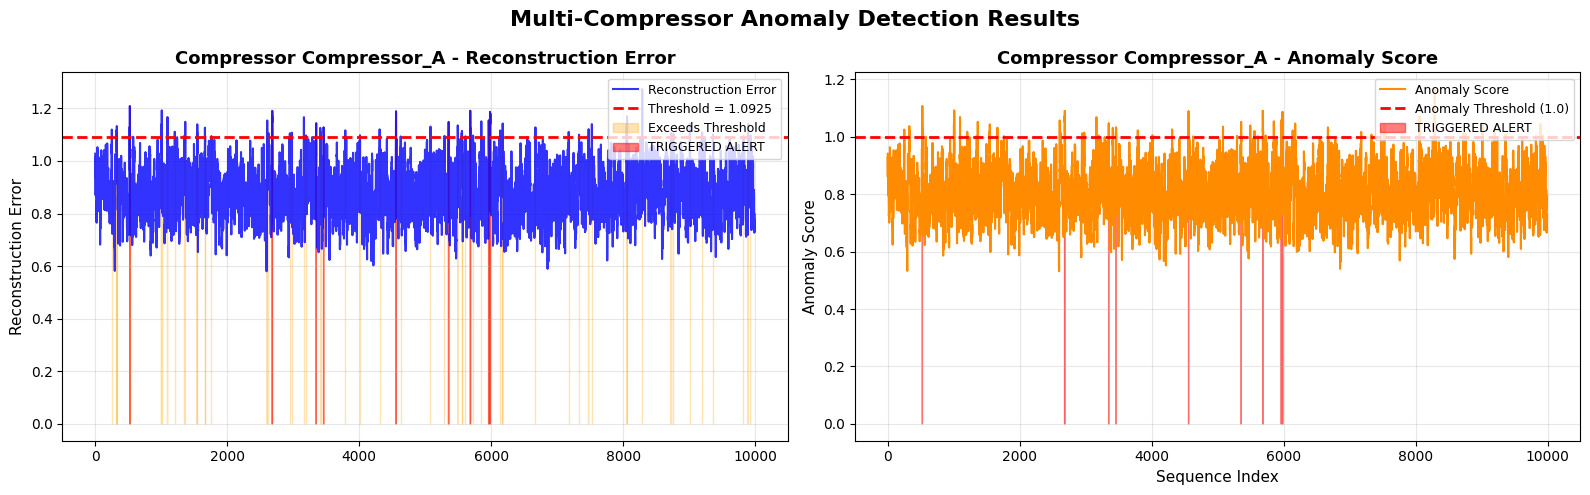


✓ TESTING COMPLETE!

Output files:
  - Results CSV: test_results.csv
  - Results Plot: test_results.png


In [10]:
if __name__ == "__main__":
    import sys
    
    # Check if running in Jupyter (sys.argv contains 'ipykernel' or '-f')
    is_jupyter = any('ipykernel' in arg or arg == '-f' for arg in sys.argv)
    
    # Check if running from command line with arguments
    if not is_jupyter and len(sys.argv) > 1:
        # Command line mode
        parser = argparse.ArgumentParser(description='Test LSTM Autoencoder Model')
        parser.add_argument('--csv_path', type=str, required=True, 
                           help='Path to test CSV file')
        parser.add_argument('--model_path', type=str, default='compressor_autoencoder.h5',
                           help='Path to saved model (default: compressor_autoencoder.h5)')
        parser.add_argument('--scaler_path', type=str, default='scaler.pkl',
                           help='Path to saved scaler (default: scaler.pkl)')
        parser.add_argument('--config_path', type=str, default='model_config.pkl',
                           help='Path to saved config (default: model_config.pkl)')
        parser.add_argument('--sequence_length', type=int, default=10,
                           help='Sequence length (default: 10)')
        parser.add_argument('--consecutive_threshold', type=int, default=3,
                           help='Consecutive anomalies to trigger alert (default: 3)')
        parser.add_argument('--output_csv', type=str, default='test_results.csv',
                           help='Output CSV path (default: test_results.csv)')
        parser.add_argument('--output_plot', type=str, default='test_results.png',
                           help='Output plot path (default: test_results.png)')
        parser.add_argument('--no_plot', action='store_true',
                           help='Skip plotting (useful for headless environments)')
        
        args = parser.parse_args()
        
        run_test(
            csv_path=args.csv_path,
            model_path=args.model_path,
            scaler_path=args.scaler_path,
            config_path=args.config_path,
            sequence_length=args.sequence_length,
            consecutive_threshold=args.consecutive_threshold,
            output_csv=args.output_csv,
            output_plot=args.output_plot,
            show_plot=not args.no_plot
        )
    else:
        # Interactive mode (Jupyter or direct Python execution)
        print("="*70)
        print("LSTM AUTOENCODER - INTERACTIVE MODE")
        print("="*70)
        print("\n💡 Running in interactive mode")
        print("\nFor command line usage:")
        print("  python test_model.py --csv_path 'path/to/test.csv'\n")
        print("For Jupyter/Python console usage:")
        print("  results = run_test('path/to/test.csv')")
        print("\nEnter test CSV path below, or press Ctrl+C to exit:")
        
        try:
            test_csv = input("\nTest CSV path: ").strip()
            
            if test_csv and os.path.exists(test_csv):
                run_test(test_csv)
            elif test_csv:
                print(f"\n❌ Error: File not found: {test_csv}")
            else:
                print("\n❌ No path provided")
        except KeyboardInterrupt:
            print("\n\n👋 Exited")